#  Read binary data from the MNIST files and convert them into NumPy arrays

In [1]:
import numpy as np
import struct
from array import array

class MnistDataloader:
    MAGIC_LABEL = 2049
    MAGIC_IMAGE = 2051

    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != self.MAGIC_LABEL:
                raise ValueError(f'Magic number mismatch for labels, expected {self.MAGIC_LABEL}, got {magic}')
            labels = np.array(array("B", file.read()))

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != self.MAGIC_IMAGE:
                raise ValueError(f'Magic number mismatch for images, expected {self.MAGIC_IMAGE}, got {magic}')
            image_data = np.array(array("B", file.read()))

        images = np.array(image_data).reshape(size, rows, cols)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)


In [2]:
import os

input_path = "/home/mohamed/Downloads/archive/data"

training_images_filepath = os.path.join(input_path, '/home/mohamed/Downloads/archive/train-images.idx3-ubyte')
training_labels_filepath = os.path.join(input_path, '/home/mohamed/Downloads/archive/train-labels.idx1-ubyte')
test_images_filepath = os.path.join(input_path, '/home/mohamed/Downloads/archive/t10k-images.idx3-ubyte')
test_labels_filepath = os.path.join(input_path, '/home/mohamed/Downloads/archive/t10k-labels.idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


In [3]:
print("x_train shape :",x_train.shape)
print("y_train shape :",y_train.shape)
print("x_test shape :",x_test.shape)
print("y_test shape :",y_test.shape )

x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)


# count of each unique label in y_train

In [4]:
# Assuming y_train is a NumPy array
unique_values, counts = np.unique(y_train, return_counts=True)

# Display the counts
for value, count in zip(unique_values, counts):
    print(f"Label {value}: Count {count}")

Label 0: Count 5923
Label 1: Count 6742
Label 2: Count 5958
Label 3: Count 6131
Label 4: Count 5842
Label 5: Count 5421
Label 6: Count 5918
Label 7: Count 6265
Label 8: Count 5851
Label 9: Count 5949


# Display images

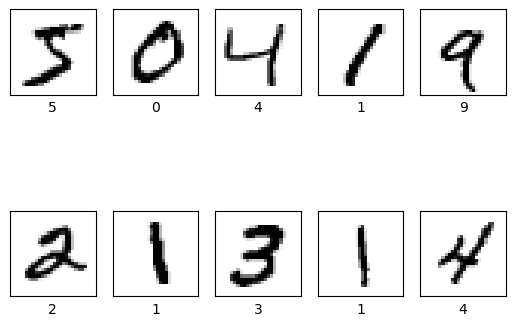

In [5]:
import matplotlib.pyplot as plt


for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

# Normalize Data

In [6]:
x_train=x_train/255.0
x_test=x_test/255.0

# k-nearest neighbor algorithm

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score,classification_report


x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)


knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_flat,y_train)


KNeighborsClassifier(n_neighbors=3)

In [8]:
train_pred=knn.predict(x_train_flat)
test_pred=knn.predict(x_test_flat)

print('Train accuracy ',accuracy_score(y_train,train_pred))
print('Test accuracy ',accuracy_score(y_test,test_pred))

Train accuracy  0.9867166666666667
Test accuracy  0.9705


# change neighbors and know best case

In [9]:
for k in range(1,10,2):
    clf=KNeighborsClassifier(n_neighbors=k)
    clf.fit(x_train_flat,y_train)
    train_pred=clf.predict(x_train_flat)
    test_pred=clf.predict(x_test_flat)
    
    print('k ',k)
    print('Train accuracy ',accuracy_score(y_train,train_pred))
    print('Test accuracy ',accuracy_score(y_test,test_pred))

k  1
Train accuracy  1.0
Test accuracy  0.9691
k  3
Train accuracy  0.9867166666666667
Test accuracy  0.9705
k  5
Train accuracy  0.9819166666666667
Test accuracy  0.9688
k  7
Train accuracy  0.97915
Test accuracy  0.9694
k  9
Train accuracy  0.9763333333333334
Test accuracy  0.9659


# to plot confusion matrix

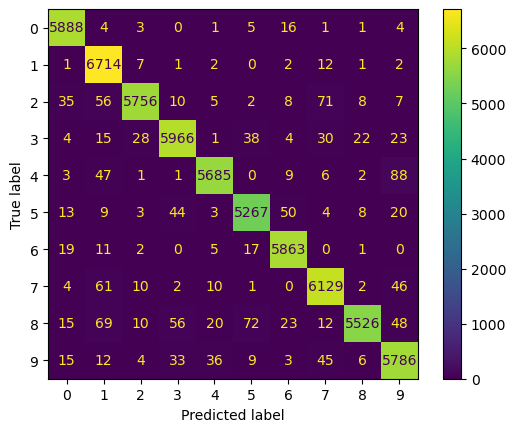

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train,train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

In [11]:
rep=classification_report(y_test,test_pred)
print("accuracy:",rep)

accuracy:               precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.94      1.00      0.97      1135
           2       0.99      0.95      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.95      0.96       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Build CNN model

In [7]:
from keras.utils import to_categorical


# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)


y_train = to_categorical(y_train, num_classes = 10)
y_test= to_categorical(y_test, num_classes = 10)

2023-11-30 11:45:08.608574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 11:45:09.926543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D
from keras.optimizers import Adam



model=Sequential([
    Conv2D(filters=32,kernel_size=(5,5),input_shape = (28,28,1),activation='relu'),
    Conv2D(filters=32,kernel_size=(5,5),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
    Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),

    
    Flatten(),
    
    Dense(256,activation='relu'),
    
    Dropout(0.5),
    Dense(10, activation = "softmax")

])

2023-11-30 11:45:13.735610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [10]:
epochs=10
batch_size=64

In [11]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (x_test, y_test))

Epoch 1/10
938/938 [==============================] - 51s 53ms/step - loss: 0.2597 - accuracy: 0.9183 - val_loss: 0.0413 - val_accuracy: 0.9866
Epoch 2/10
938/938 [==============================] - 48s 51ms/step - loss: 0.0751 - accuracy: 0.9804 - val_loss: 0.0330 - val_accuracy: 0.9913
Epoch 3/10
938/938 [==============================] - 47s 51ms/step - loss: 0.0571 - accuracy: 0.9845 - val_loss: 0.0296 - val_accuracy: 0.9913
Epoch 4/10
938/938 [==============================] - 47s 50ms/step - loss: 0.0458 - accuracy: 0.9878 - val_loss: 0.0233 - val_accuracy: 0.9933
Epoch 5/10
938/938 [==============================] - 46s 49ms/step - loss: 0.0382 - accuracy: 0.9894 - val_loss: 0.0302 - val_accuracy: 0.9918
Epoch 6/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0351 - accuracy: 0.9906 - val_loss: 0.0325 - val_accuracy: 0.9907
Epoch 7/10
938/938 [==============================] - 48s 51ms/step - loss: 0.0336 - accuracy: 0.9906 - val_loss: 0.0330 - val_accuracy:

In [18]:
import seaborn as sns

# Evaluate model

In [14]:
# Get predictions for the test set
y_pred = model.predict(x_test)

# Convert one-hot encoded labels back to class labels
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_test.argmax(axis=-1)

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.98      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      1.00       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Plot confusion matrix

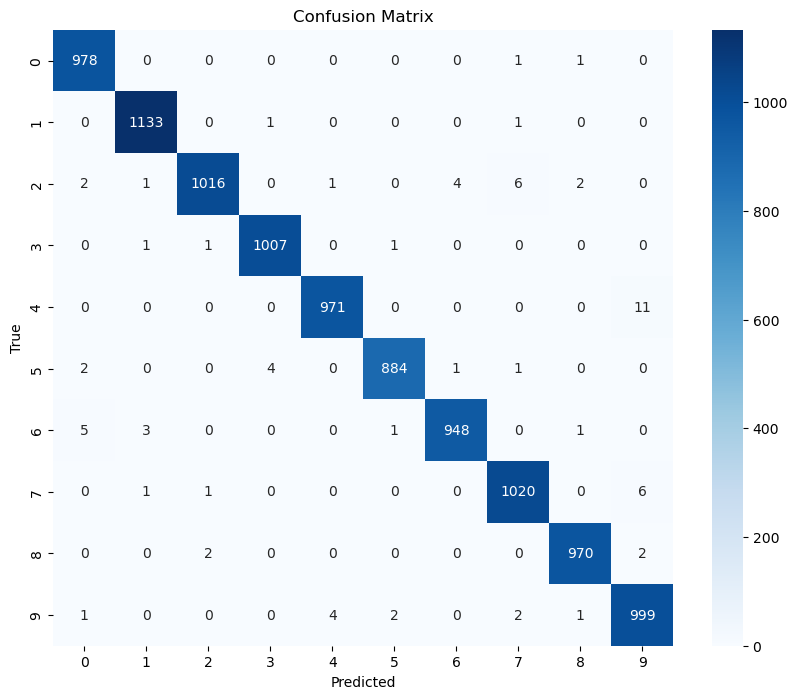

In [19]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Plot training & validation accuracy values

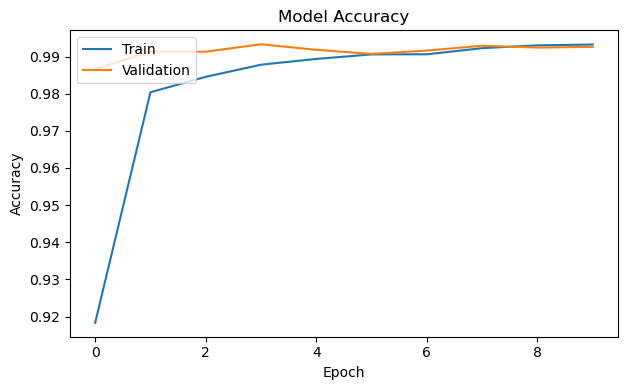

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# show plot
plt.tight_layout()
plt.show()

## Plot training & validation loss values

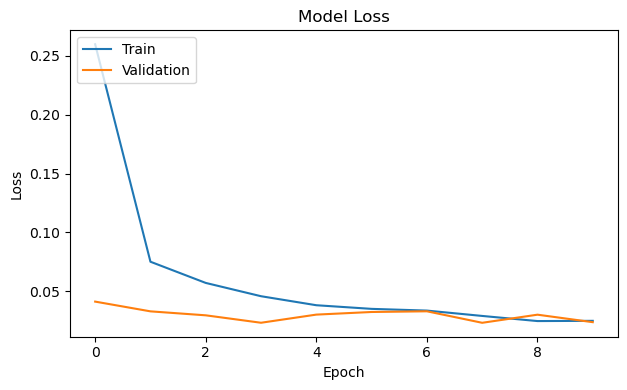

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


# save model

In [23]:
import joblib

In [24]:
joblib.dump(model, 'cnn_without_lr.joblib')

['cnn_without_lr.joblib']

## Adjust the learning rate during training to improve convergence.

In [25]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# Function to define a schedule for learning rate decay
def lr_schedule(epoch):
    initial_learning_rate = 0.001
    decay = 0.9
    return initial_learning_rate * decay ** epoch

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Create the Adam optimizer with the initial learning rate
optimizer = Adam(learning_rate=0.001)


In [26]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

###  Train the model with the specified learning rate schedule

In [27]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

Epoch 1/10
938/938 [==============================] - 45s 47ms/step - loss: 0.0255 - accuracy: 0.9934 - val_loss: 0.0216 - val_accuracy: 0.9934 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 45s 47ms/step - loss: 0.0200 - accuracy: 0.9945 - val_loss: 0.0265 - val_accuracy: 0.9932 - lr: 9.0000e-04
Epoch 3/10
938/938 [==============================] - 44s 47ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0225 - val_accuracy: 0.9946 - lr: 8.1000e-04
Epoch 4/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.0202 - val_accuracy: 0.9933 - lr: 7.2900e-04
Epoch 5/10
938/938 [==============================] - 46s 49ms/step - loss: 0.0122 - accuracy: 0.9965 - val_loss: 0.0237 - val_accuracy: 0.9945 - lr: 6.5610e-04
Epoch 6/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.0275 - val_accuracy: 0.9935 - lr: 5.9049e-04
Epoch 7/10
938/938 [==================

# Evaluate model

In [30]:
eval_result = model.evaluate(x_test, y_test)

# Print the evaluation result
print("Test Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0271 - accuracy: 0.9948
Test Loss: 0.027120456099510193
Test Accuracy: 0.9947999715805054


In [28]:
# Get predictions for the test set
y_pred = model.predict(x_test)

# Convert one-hot encoded labels back to class labels
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_test.argmax(axis=-1)

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Plot confusion matrix

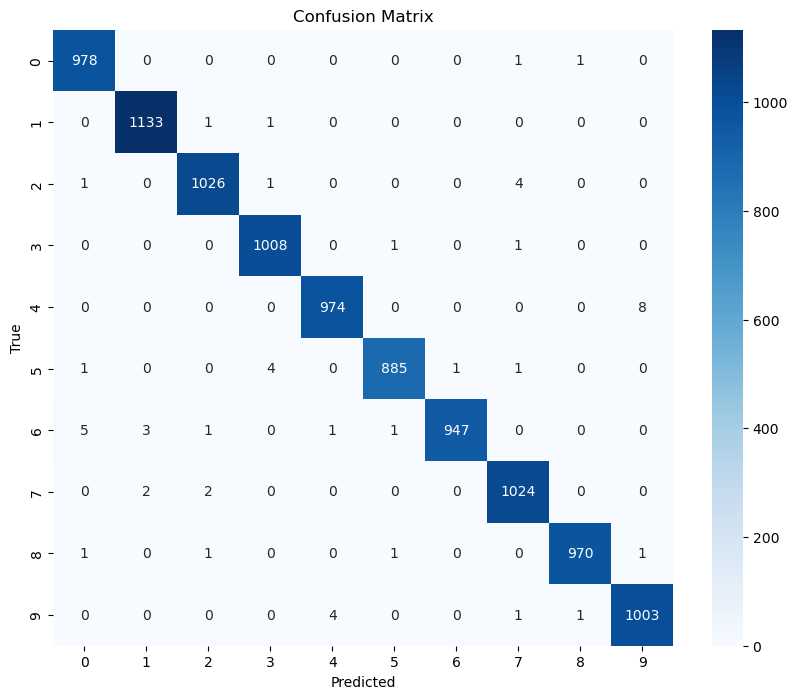

In [29]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Plot training & validation accuracy values

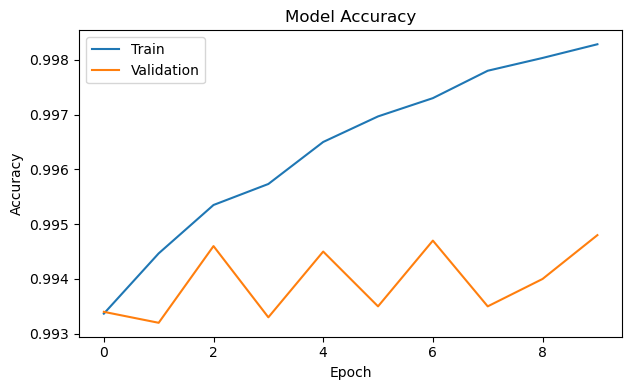

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# show plot
plt.tight_layout()
plt.show()

## Plot training & validation loss values

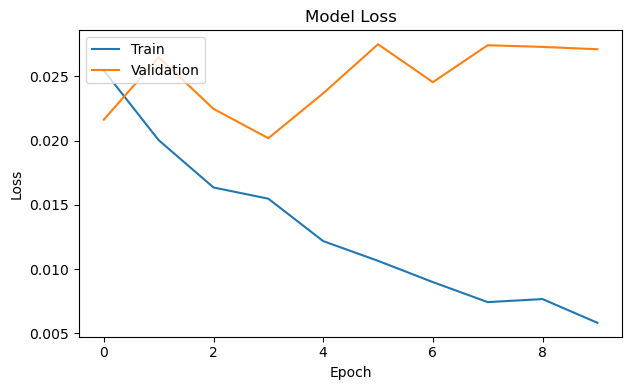

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


# save model

In [33]:
joblib.dump(model, 'cnn_with_lr_schedule.joblib')

['cnn_with_lr_schedule.joblib']